In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import datetime

In [2]:
## Original gridinfo
australia005_gridinfo_input = (
    "/g/data/rp23/experiments/2024-04-17_BIOS3-merge/ag9761/data_005/gridinfo_CSIRO_CRU005x005_4tiles.nc"
)

## Output filename for the updated gridinfo
australia005_gridinfo_output= (
    "/g/data/rp23/experiments/2024-04-17_BIOS3-merge/ag9761/data_005/gridinfo_CSIRO_CRU005x005_4tiles_v3.nc"
)

## Note: Supported with VSCode, if failing with KeyError, provide the abspath for the current filename
current_file_abspath = globals()['__vsc_ipynb_file__']

In [3]:
# Open gridinfo
australia005_gridinfo_data = xr.open_dataset(australia005_gridinfo_input)

In [4]:
gridinfo_params = australia005_gridinfo_data.keys()

# BIOS parameters already have the necessary mapping
bios_params = [
    "bch",
    "clay",
    "sand",
    "silt",
    "ssat",
    "sfc",
    "swilt",
    "hyds",
    "sucs",
    "css",
    "rhosoil",
    "mvg",
    "c4frac",
    "modis_igbp",
    "avgannmax_fapar",
]

# non-BIOS params from the original gridinfo which are unchanged
unchanged_params = [
    # Longs and lats
    "lat_bnds",
    "lon_bnds",
    "area", # All values are already filled
    "gw",
    "crs",
]

changed_params = [
 'Nfix',
 'SoilOrder',
 'albedo2',
 'Pdust',
 'Pwea',
 'isoil',
 'cnsd',
 'Ndep',
 "patchfrac",
 'iveg',
 'SoilMoist',
 'SnowDepth',
 'Albedo',
 'SoilTemp',
 'LAI',
 ]

## Sanity Checks
expected_params = gridinfo_params
listed_params = bios_params + unchanged_params + changed_params
assert set(expected_params) == set(listed_params) # Same params in gridinfo and list
assert len(expected_params) == len(set(expected_params)) # All values are unique in the lists

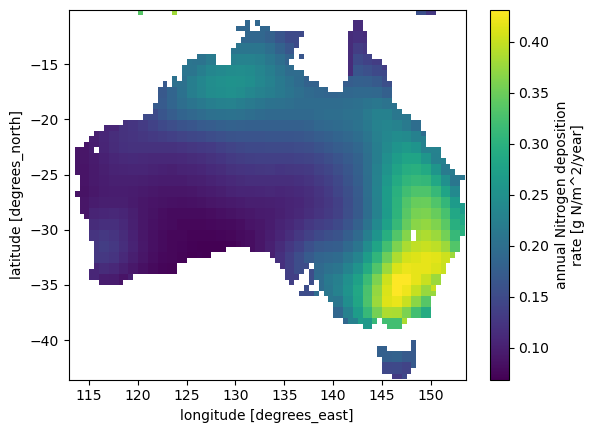

In [5]:
# Map for a non-ancillary (BIOS) gridinfo parameter which was downscaled from 0.5 degree to 0.05 degrees
australia005_gridinfo_data["Ndep"].plot()

In [6]:
# Used to create the list of non-BIOS points which need to be filled
australia005_gridinfo_data_iveg = australia005_gridinfo_data["iveg"][0]
# We take bch as reference parameter (assumption of same valid lon/lats for other BIOS variables)
australia005_gridinfo_data_bch = australia005_gridinfo_data["bch"]

Text(0.5, 1.0, 'red = original gridinfo, blue = BIOS ancillary')

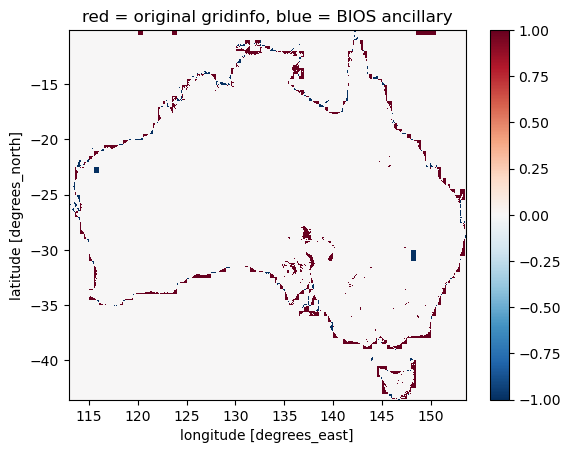

In [7]:
# Mask differences between BIOS and non-BIOS parameter map (algorithm is applied in coloured areas)
iveg_mask = (~australia005_gridinfo_data["iveg"][0].isnull()).astype("int")
bch_mask = (~australia005_gridinfo_data["bch"].isnull()).astype("int")
fig, ax = plt.subplots()
x = (iveg_mask - bch_mask).plot()
ax.set_title("red = original gridinfo, blue = BIOS ancillary")

In [8]:
class MissingPoints:

    def __init__(self, sample_dest_map, source_map):
        self.source_map = source_map
        self.missing_dest_points = self._get_missing_dest_points(sample_dest_map, source_map)
        self.nn_points = self._get_nn_points(sample_dest_map)
    
    def _get_missing_dest_points(self, dest_map, source_map):
        # List source and destination points
        dest_points = dest_map.stack(x=("latitude", "longitude"))
        source_points = source_map.stack(x=("latitude", "longitude"))
        missing_points = source_points[source_points.notnull() & dest_points.isnull()].x
        return missing_points

    def _get_nn_points(self, dest_map):
        dest_points = dest_map.stack(x=("latitude", "longitude"))
        # Eligible nearest neighbours having valid points in case value is empty
        valid_dest_points = dest_points.dropna(dim="x")
        def nearest_point(missing_point):
            # Euclidean distance to create map of distance of all valid points
            dist_arr = (missing_point[0] - valid_dest_points["latitude"].values) ** 2 + (missing_point[1] - valid_dest_points["longitude"].values) ** 2
            min_idx = np.argmin(dist_arr, axis=0)
            min_lat = valid_dest_points[min_idx]["latitude"]
            min_lon = valid_dest_points[min_idx]["longitude"]
            return (min_lat, min_lon)
        nearest_point_v = np.vectorize(nearest_point)
        return nearest_point_v(self.missing_dest_points)

    def _fill_missing_points(self, dest_map):
        for mp_lat, mp_lon, nn_lat, nn_lon in zip(list(self.missing_dest_points.latitude.values), list(self.missing_dest_points.longitude.values), self.nn_points[0], self.nn_points[1]):
            dest_map.loc[mp_lat, mp_lon] = dest_map.loc[nn_lat, nn_lon]

    def map_points(self, dest_map):
        # Result is not in-place
        dest_map_res = dest_map.copy(deep=True)
        # NN
        self._fill_missing_points(dest_map_res)
        # Remove
        dest_map_res = dest_map_res.where(self.source_map.notnull())
        return dest_map_res

In [9]:
mp = MissingPoints(australia005_gridinfo_data_iveg, australia005_gridinfo_data_bch)

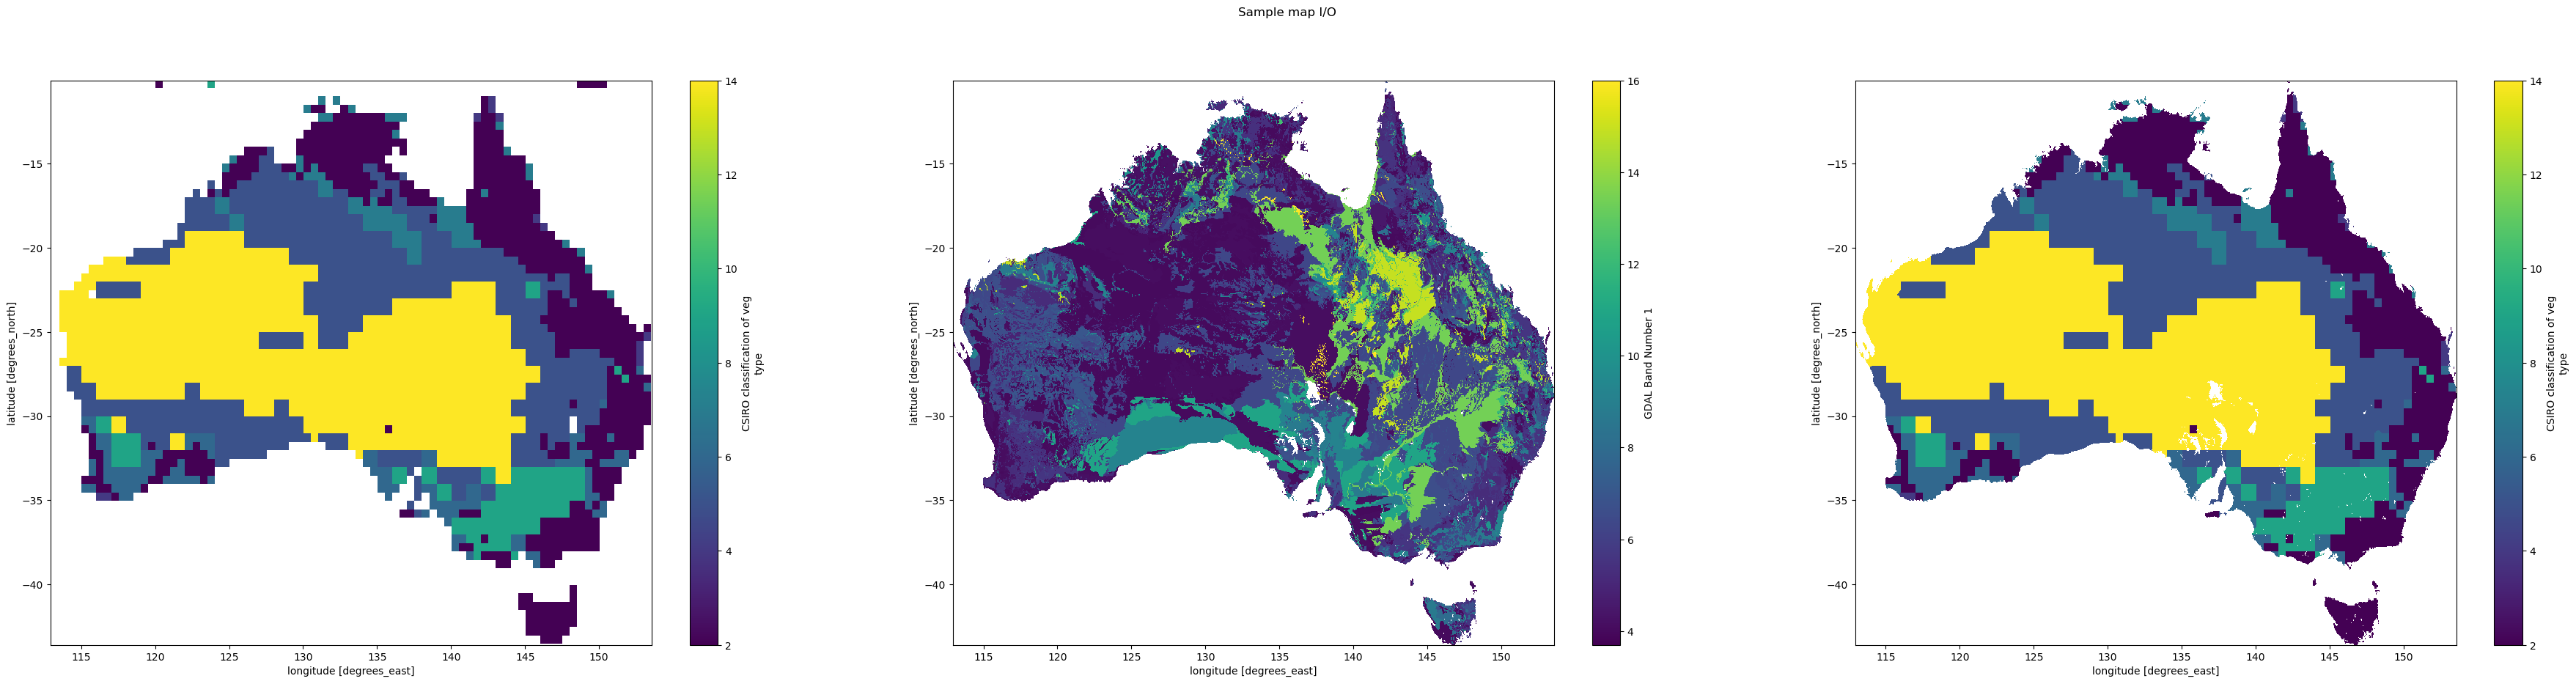

In [10]:
# Sample Testing of mp-algorithm
fig, ax = plt.subplots(ncols=3)
fig.set_size_inches(45,10)
fig.suptitle("Sample map I/O")
ax[0].set_title("Original SoilTemp Map [time=0, soil=0]")
ax[1].set_title("bch map used as mask")
ax[2].set_title("New SoilTemp Map [time=0, soil=0]")
australia005_gridinfo_data_iveg.plot(ax=ax[0])
australia005_gridinfo_data_bch.plot(ax=ax[1])
australia005_gridinfo_data_iveg_new = mp.map_points(australia005_gridinfo_data_iveg)
australia005_gridinfo_data_iveg_new.plot(ax=ax[2])

In [11]:
def map_dims(dataset, param_name: str):
    '''Returns parameter name with it's dimension sizes (other than longitude/latitude)'''
    dim_sizes = dict(dataset[param_name].sizes)
    # List of non-lat/lon dimensions, key order preserved 
    for loc_key in ["latitude", "longitude"]:
        dim_sizes.pop(loc_key, None)
    return param_name, list(dim_sizes.values())

In [12]:
mapped_param_dim = [map_dims(australia005_gridinfo_data, changed_param) for changed_param in changed_params]
# Run for all points for each param (either 0, 1 or 2 dimensional) 
for pc in mapped_param_dim:
    point_name = pc[0]
    point_change_dimlist = pc[1]
    point_change_dimsize = len(point_change_dimlist)
    print(f"Point name currently being changed: {point_name}")
    if point_change_dimsize == 0:
        australia005_gridinfo_data[point_name] = mp.map_points(australia005_gridinfo_data[point_name])
    elif point_change_dimsize == 1:
        for i in range(point_change_dimlist[0]):
            print(f"Point idx: {i}")
            australia005_gridinfo_data[point_name][i] = mp.map_points(australia005_gridinfo_data[point_name][i])
    elif point_change_dimsize == 2:
        for i in range(point_change_dimlist[0]):
            for j in range(point_change_dimlist[1]):
                print(f"Point idx: {[i, j]}")
                australia005_gridinfo_data[point_name][i, j] = mp.map_points(australia005_gridinfo_data[point_name][i, j])
    else:
        KeyError("Invalid spec (received more than 2 dimensions in parameter)")

Point name currently being changed: Nfix
Point name currently being changed: SoilOrder
Point name currently being changed: albedo2
Point name currently being changed: Pdust
Point name currently being changed: Pwea
Point name currently being changed: isoil
Point name currently being changed: cnsd
Point name currently being changed: Ndep
Point name currently being changed: patchfrac
Point idx: 0
Point idx: 1
Point idx: 2
Point idx: 3
Point name currently being changed: iveg
Point idx: 0
Point idx: 1
Point idx: 2
Point idx: 3
Point name currently being changed: SoilMoist
Point idx: [0, 0]
Point idx: [0, 1]
Point idx: [0, 2]
Point idx: [0, 3]
Point idx: [0, 4]
Point idx: [0, 5]
Point idx: [1, 0]
Point idx: [1, 1]
Point idx: [1, 2]
Point idx: [1, 3]
Point idx: [1, 4]
Point idx: [1, 5]
Point idx: [2, 0]
Point idx: [2, 1]
Point idx: [2, 2]
Point idx: [2, 3]
Point idx: [2, 4]
Point idx: [2, 5]
Point idx: [3, 0]
Point idx: [3, 1]
Point idx: [3, 2]
Point idx: [3, 3]
Point idx: [3, 4]
Point idx: 

In [13]:
def append_attribute(data_attr, message):
    return data_attr + "\n" + f"{datetime.datetime.now().strftime('%a %b %d %H:%M:%S %Y')}: " + message

In [14]:
# Add provenance
modification_provenance = f"{current_file_abspath}: Have the same mask original downscaled gridinfo parameters the same mask as BIOS ancillary parameters.\nAchieved by combination of nearest neighbour finding (Euclidean distance) and removal of additional points"
history_provenance = f"Running all cells in {current_file_abspath}"

australia005_gridinfo_data.attrs["history"] = append_attribute(australia005_gridinfo_data.attrs["history"], history_provenance)
australia005_gridinfo_data.attrs["modification"] = append_attribute(australia005_gridinfo_data.attrs["modification"], modification_provenance)

In [15]:
# Encoding needs to be the same (xarray makes some default attribute changes based on CF-compliance, which we need to reverse)
diff_netcdf_encoding ={
    "isoil" : {
        "dtype": "int32",
        "missing_value" : -1,
        "_FillValue" : -1
    },
    "SoilOrder": {
        "dtype": "int32",
        "missing_value" : -1,
        "_FillValue" : -1
    },
    "Ndep": {
        "dtype": "float32",
        "missing_value": -99.0,
        "_FillValue": -99.0
    },
    "Nfix": {
        "dtype": "float32",
        "missing_value": -99.0,
        "_FillValue": -99.0
    },
    "Pdust": {
        "dtype": "float32",
        "missing_value": -99.0,
        "_FillValue": -99.0
    },
    "Pwea": {
        "dtype": "float32",
        "missing_value": -99.0,
        "_FillValue": -99.0
    }, 
    "albedo2": {
        "missing_value": -1.0,
        "_FillValue" : -1.0
    },
    "cnsd": {
        "missing_value": -1.0,
        "_FillValue" : -1.0
    }
}
australia005_gridinfo_data.to_netcdf(australia005_gridinfo_output, encoding=diff_netcdf_encoding, format="NETCDF3_CLASSIC")